### Sensor Noise

In [1]:
import distutils.util as distutils
import os
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

def controller(model, data):
    """
    This function implements a PD controller

    Since there are no gravity compensation,
    it will not be very accurate at tracking
    the set point. It will be accurate if
    gravity is turned off.
    """
    if actuator_type == "torque":
        model.actuator_gainprm[0, 0] = 1
        data.ctrl[0] = -10 * \
            (data.sensordata[0] - 0.0) - \
            1 * (data.sensordata[1] - 0.0)
    elif actuator_type == "servo":
        kp = 100.0
        model.actuator_gainprm[1, 0] = kp
        model.actuator_biasprm[1, 1] = -kp
        data.ctrl[1] = -0.5

        kv = 1.0
        model.actuator_gainprm[2, 0] = kv
        model.actuator_biasprm[2, 2] = -kv
        data.ctrl[2] = 0.0

""

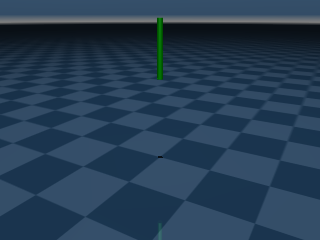

In [2]:
xml_path = "model/simple_pendulum.xml"
model = mujoco.MjModel.from_xml_path(xml_path)  # MuJoCo model
data = mujoco.MjData(model)                # MuJoCo data
cam = mujoco.MjvCamera()                        # Abstract camera
opt = mujoco.MjvOption()                        # visualization options
mujoco.mjv_defaultCamera(cam)
mujoco.mjv_defaultOption(opt)

# Set camera configuration
cam.azimuth = 90.0
cam.distance = 5.0
cam.elevation = -5
cam.lookat = np.array([0.012768, -0.000000, 1.254336])


#set the controller
actuator_type = "torque"
mujoco.set_mjcb_control(controller)



renderer = None
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
# Parameters.
DURATION = 10          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
#set initial conditions
data.qpos[0] = np.pi/2
# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, 'track')
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)